# UMAP for Data Integration

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this notebook, we will discuss graph-based data integration, and demonstrate how UMAP allows for across-modalities integration of single cell Omics (scOmics) data by computing intersection of graphs from individual scOmics layers.

### Table of Contents:
* [Graph Based Data Integration](#Graph-Based-Data-Integration)
* [UMAP for Single Cell Omics Integration](#UMAP-for-Single-Cell-Omics-Integration)

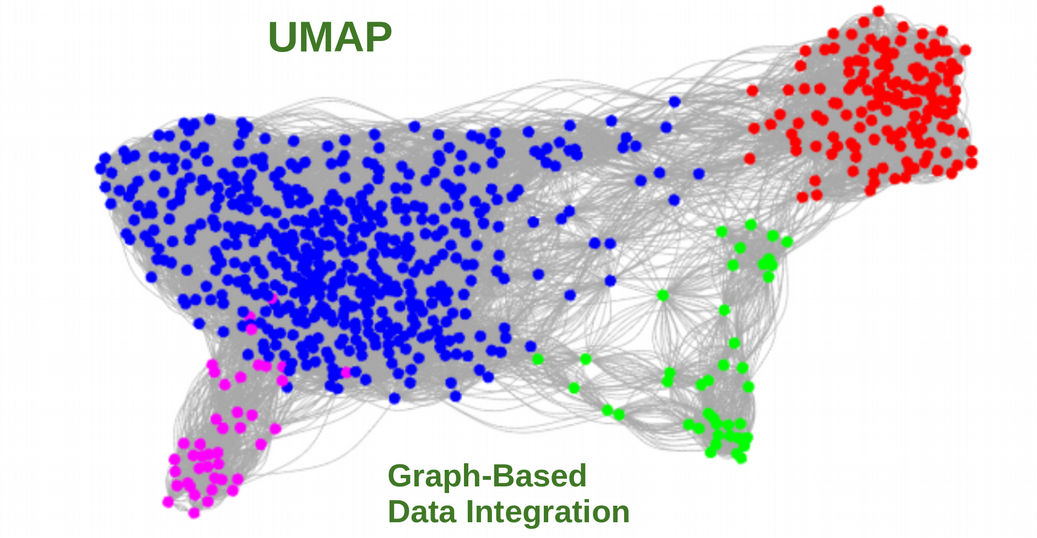

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/UMAP_DataIntegration/graph_integration.png', width=2000)

### Graph Based Data Integration <a class="anchor" id="Graph-Based-Data-Integration"></a>

The idea of graph-based data integration is very simple. Individual data sets can originate from very different statistical distributions. They can be **binary, categorical or continous**. However, when having been converted into graphs, the individual data sets represent **pairwise connections** between data points without any **"memory"** of what statistical process generated the individual data sets. In the graph space, it is straighforward to find an intersection between individual graphs from individual data sets by **keeping edges consistently present between the data points across the graphs from individual data sets**. The advantage of this approach is that one can apply an **appropriate** distance metric when converting the raw data into graphs, i.e. working with binary data one might want to apply **hamming** distance to compute pairwise connections, while working with continuous data it might be sufficient to use the **euclidean** distance.

To demonstrate the graph-based data integration, we will apply it to the scNMT single cell Omics (https://www.nature.com/articles/s41467-018-03149-4) data set that represents 1) gene expression (scRNAseq), 2) DNA methylation (scBSseq), and 3) open chromatine region (scATACseq) from the same biological cells. We will start with reading scNMTseq data that is scRNAseq, scATACseq and scBSseq, filtering the data , e.g. removing lowly expressed genes, and checking the data distributions.

In [2]:
import pandas as pd
scRNAseq = pd.read_csv('/home/nikolay/Documents/Medium/UnsupervisedOMICsIntegration/scRNAseq.txt', sep = '\t')
print('Dimensions of scRNAseq data set: ' + str(scRNAseq.shape))
scBSseq = pd.read_csv('/home/nikolay/Documents/Medium/UnsupervisedOMICsIntegration/scBSseq.txt', sep = '\t')
print('Dimensions of scBSseq data set: ' + str(scBSseq.shape))
scATACseq = pd.read_csv('/home/nikolay/Documents/Medium/UnsupervisedOMICsIntegration/scATACseq.txt', sep = '\t')
print('Dimensions of scATACseq data set: ' + str(scATACseq.shape))

Dimensions of scRNAseq data set: (113, 12314)
Dimensions of scBSseq data set: (113, 8575)
Dimensions of scATACseq data set: (113, 11800)


There are aonly 113 cells in the scNMT multi-Omics data set, i.e very few and it is not a high-throughput technology yet, but on the other hand this is good for demonstration purposes as we can quite  easily track all pairwise connections between the cells. Now we will remove genes with the mean counts below 1 across the cells. In addition, we will apply a log-transformation to make the Poissson distributed gene expression counts to look more or less as if they are coming from Normal distribution.

In [3]:
import numpy as np
scRNAseq = scRNAseq.loc[:, scRNAseq.mean(axis = 0) > 1]
scRNAseq = np.log10(scRNAseq + 1)
print('Dimensions of scRNAseq data set: ' + str(scRNAseq.shape))

Dimensions of scRNAseq data set: (113, 12145)


Let us plot the log-converted single cell gene expression data and see that it looks tolerable to apply Euclidean distance as a measure of similarity in gene expression between the cells.

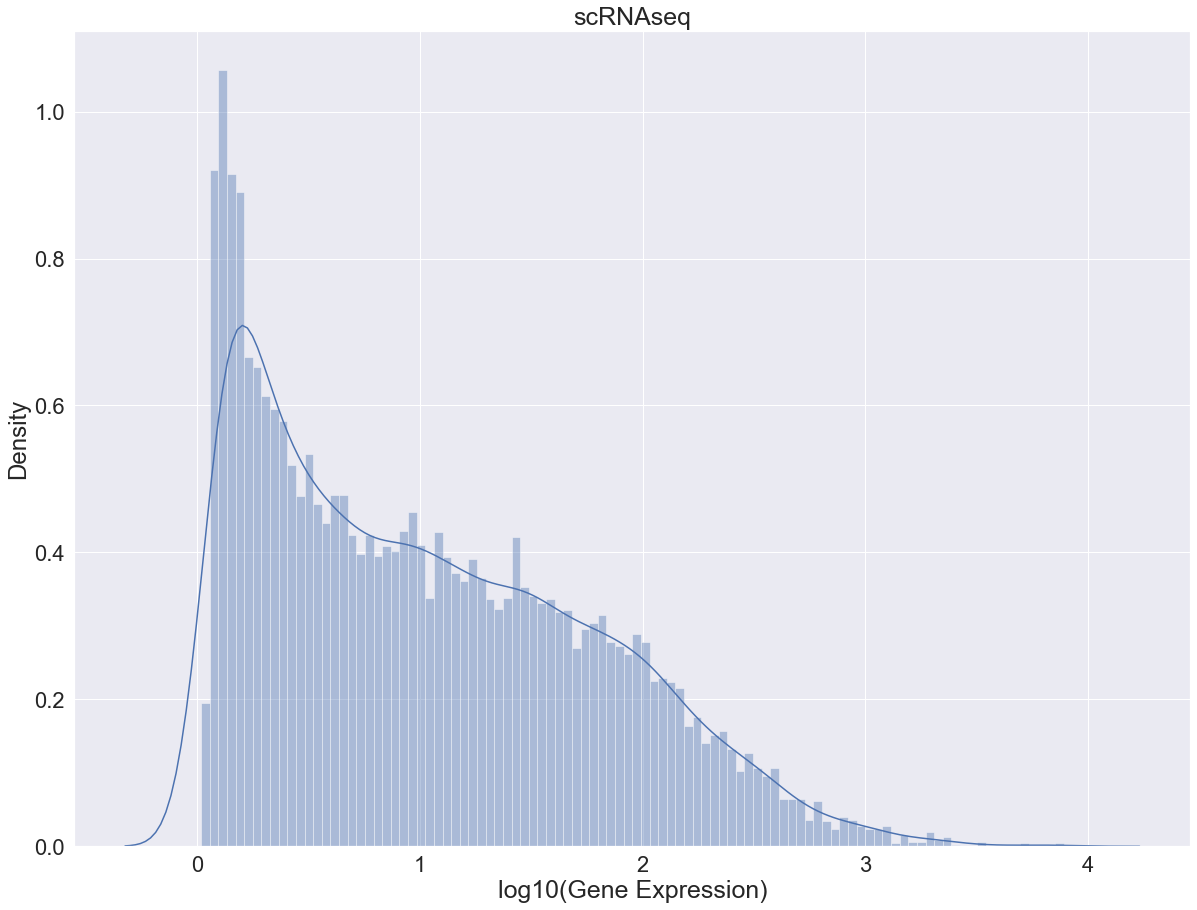

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(rc = {'figure.figsize':(20, 15)}, font_scale = 2)
sns.distplot(scRNAseq.mean(axis = 0), bins = 100)
plt.title('scRNAseq', fontsize = 25)
plt.xlabel('log10(Gene Expression)', fontsize = 25)
plt.show()

The single cell gene expression (scRNAseq) data is clearly continuous, let us have a look at the data matrix:

In [5]:
scRNAseq

ENSMUSG00000033845  ENSMUSG00000025903  ENSMUSG00000033813  \
ESC_A02             2.746961            2.614471            2.642377   
ESC_A03             2.120092            2.145608            2.553142   
ESC_A04             2.486764            2.272593            2.443907   
ESC_A05             2.621348            2.029747            2.211738   
ESC_A06             2.759404            2.821972            2.331036   
...                      ...                 ...                 ...   
EB_P2F02            2.325271            1.390251            0.862311   
EB_P2F12            2.710661            1.981971            2.156551   
EB_P2G05            1.872802            2.292763            1.629472   
EB_P2G07            1.906382            0.642228            1.847856   
EB_P2G12            2.991013            2.941236            1.792333   

          ENSMUSG00000033793  ENSMUSG00000025905  ENSMUSG00000025907  \
ESC_A02             2.539979            0.000000            2.603526   
ESC_A03             2.700307            0.000000            1.950850   
ESC_A04             2.293558            0.000000            1.838479   
ESC_A05             2.127304            0.000000            1.767453   
ESC_A06             2.513401            0.000000            0.000000   
...                      ...                 ...                 ...   
EB_P2F02            0.000000            0.000000            2.219922   
EB_P2F12            0.000000            0.000000            1.590769   
EB_P2G05            2.333309            1.474278            1.908548   
EB_P2G07            2.357877            0.000000            1.669621   
EB_P2G12            0.000000            0.000000            1.732685   

          ENSMUSG00000051285  ENSMUSG00000061024  ENSMUSG00000025911  \
ESC_A02             1.501479            1.672984            1.314572   
ESC_A03             2.070007            1.633692            0.185238   
ESC_A04             1.910060            1.915524            0.611536   
ESC_A05             0.278540            2.074734            0.000000   
ESC_A06             0.711122            1.912576            0.000000   
...                      ...                 ...                 ...   
EB_P2F02            1.466475            1.917396            0.000000   
EB_P2F12            2.685887            1.300742            0.000000   
EB_P2G05            0.000000            2.088554            0.000000   
EB_P2G07            1.858174            1.915413            0.000000   
EB_P2G12            2.532030            0.000000            0.000000   

          ENSMUSG00000025912  ...  ENSMUSG00000064356  ENSMUSG00000064357  \
ESC_A02             2.167231  ...            0.938653            1.914316   
ESC_A03             1.387474  ...            0.185238            1.085306   
ESC_A04             1.517352  ...            1.684423            3.051198   
ESC_A05             0.567872  ...            1.991664            3.253758   
ESC_A06             1.412482  ...            1.853771            3.172584   
...                      ...  ...                 ...                 ...   
EB_P2F02            0.000000  ...            0.000000            1.018056   
EB_P2F12            0.000000  ...            0.000000            1.590769   
EB_P2G05            1.595558  ...            0.869287            1.230509   
EB_P2G07            1.047774  ...            0.000000            0.000000   
EB_P2G12            0.952087  ...            0.000000            1.228166   

          ENSMUSG00000064358  ENSMUSG00000064360  ENSMUSG00000065947  \
ESC_A02             1.981152            0.893708            1.381079   
ESC_A03             1.576374            0.000000            0.414267   
ESC_A04             2.972571            1.790534            1.946944   
ESC_A05             2.926970            1.922797            2.036979   
ESC_A06             2.815143            2.075706            1.827822   
...                      ...                 ...          

However, when we plot scBSseq and scATACseq data, it is quite clear that they follow a bimodal distribution, therefore it would not be appropriate to use Euclidean distance to measure similarity between cells using this type of rather binary data.

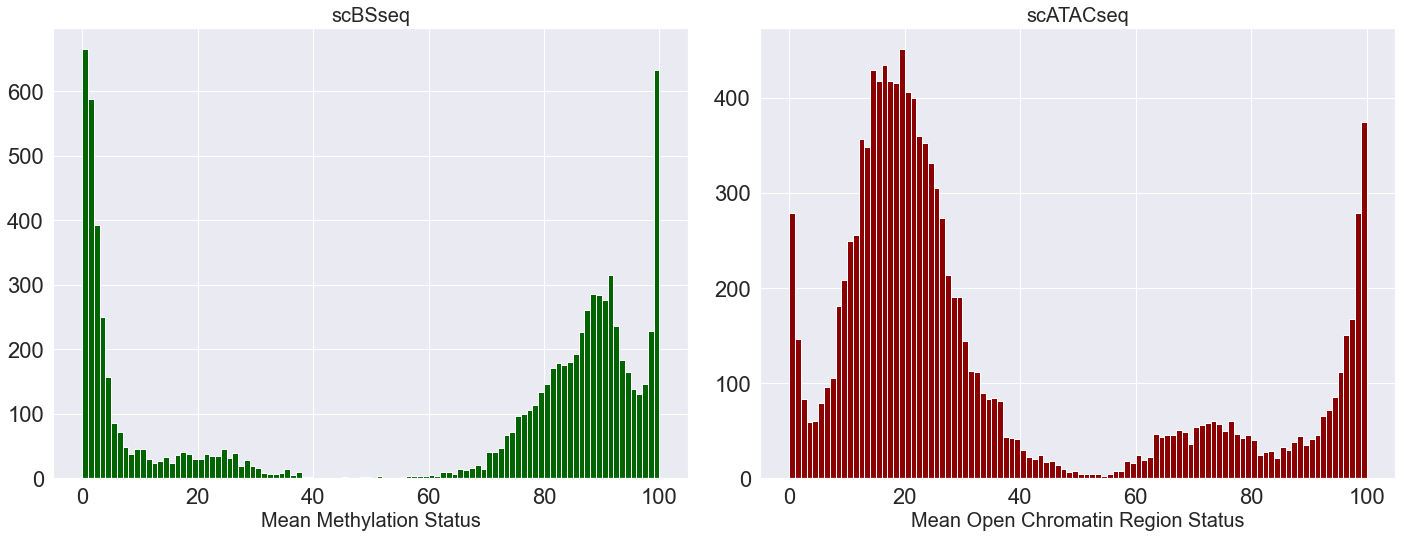

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (20, 8))
plt.subplot(121)
plt.hist(scBSseq.mean(axis = 0), bins = 100, color = 'darkgreen')
plt.title('scBSseq', fontsize = 20)
plt.xlabel('Mean Methylation Status', fontsize = 20)
plt.subplot(122)
plt.hist(scATACseq.mean(axis = 0), bins = 100, color = 'darkred')
plt.title('scATACseq', fontsize = 20)
plt.xlabel('Mean Open Chromatin Region Status', fontsize = 20)
figure.tight_layout()
plt.show()

If we look at the scBSseq data matrix, the elements vary between 0% and 100% implying a whether a certain CpG site is methylated (100%) or unmethylated (0%). In reality, not all elements of the matrix are strictly either 0% or 100%, this might be due to technical sampling and sequencing reasons. However, with a good certainty one can treat the scBSseq data (the same is valid for scATACseq data as well) as binary data. To make the data explicitly binary, we will recode all counts below 50% as 0 and above 50% as 1.

In [7]:
scBSseq

1_101606896  1_101935054  1_101935061  1_102002184  1_102238204  \
ESC_A02             0    88.888889    88.888889        100.0        100.0   
ESC_A03             0   100.000000   100.000000        100.0        100.0   
ESC_A04             0   100.000000   100.000000          0.0        100.0   
ESC_A05             0   100.000000   100.000000          0.0        100.0   
ESC_A06             0    30.000000    90.000000          0.0        100.0   
...               ...          ...          ...          ...          ...   
EB_P2F02            0   100.000000   100.000000        100.0        100.0   
EB_P2F12            0   100.000000   100.000000        100.0        100.0   
EB_P2G05            0   100.000000   100.000000        100.0        100.0   
EB_P2G07            0   100.000000   100.000000        100.0        100.0   
EB_P2G12            0   100.000000   100.000000        100.0        100.0   

          1_102255678  1_102256383  1_102256482  1_102605169  1_105398091  \
ESC_A02         100.0        100.0        100.0        100.0        100.0   
ESC_A03         100.0        100.0        100.0         87.5        100.0   
ESC_A04         100.0        100.0        100.0        100.0        100.0   
ESC_A05         100.0        100.0        100.0        100.0        100.0   
ESC_A06           0.0        100.0        100.0          0.0        100.0   
...               ...          ...          ...          ...          ...   
EB_P2F02        100.0        100.0        100.0        100.0        100.0   
EB_P2F12        100.0        100.0        100.0        100.0        100.0   
EB_P2G05        100.0        100.0        100.0        100.0        100.0   
EB_P2G07        100.0        100.0        100.0        100.0        100.0   
EB_P2G12        100.0        100.0        100.0        100.0        100.0   

          ...  Y_90825417  Y_90825430  Y_90825431  Y_90825460  Y_90826210  \
ESC_A02   ...  100.000000  100.000000       100.0  100.000000         100   
ESC_A03   ...    0.000000    0.000000         0.0  100.000000         100   
ESC_A04   ...   33.333333   91.666667        20.0   50.000000         100   
ESC_A05   ...  100.000000  100.000000       100.0  100.000000         100   
ESC_A06   ...  100.000000  100.000000       100.0   83.333333          50   
...       ...         ...         ...         ...         ...         ...   
EB_P2F02  ...  100.000000  100.000000       100.0  100.000000         100   
EB_P2F12  ...  100.000000  100.000000       100.0  100.000000         100   
EB_P2G05  ...  100.000000  100.000000       100.0  100.000000         100   
EB_P2G07  ...  100.000000  100.000000       100.0    0.000000         100   
EB_P2G12  ...  100.000000  100.000000       100.0  100.000000         100   

          Y_90826222  Y_90826244  Y_90826248  Y_90826260  cluster  
ESC_A02        100.0       100.0       100.0       100.0        1  
ESC_A03        100.0       100.0       100.0         0.0        1  
ESC_A04        100.0       100.0       100.0       100.0        1  
ESC_A05        100.0       100.0       100.0       100.0        1  
ESC_A06        100.0       100.0       100.0       100.0        1  
...              ...         ...         ...         ...      ...  
EB_P2F02       100.0       100.0       100.0       100.0        2  
EB_P2F12       100.0       100.0       100.0       100.0        3  
EB_P2G05       100.0       100.0       100.0       100.0        2  
EB_P2G07       100.0       100.0       100.0       100.0        2  
EB_P2G12       100.0       100.0       100.0       100.0        3  

[113 rows x 8575 columns]

In [8]:
import numpy as np
scBSseq = pd.DataFrame(np.where(scBSseq < 50, 0, 1), index = scBSseq.index, columns = scBSseq.columns)
scBSseq

1_101606896  1_101935054  1_101935061  1_102002184  1_102238204  \
ESC_A02             0            1            1            1            1   
ESC_A03             0            1            1            1            1   
ESC_A04             0            1            1            0            1   
ESC_A05             0            1            1            0            1   
ESC_A06             0            0            1            0            1   
...               ...          ...          ...          ...          ...   
EB_P2F02            0            1            1            1            1   
EB_P2F12            0            1            1            1            1   
EB_P2G05            0            1            1            1            1   
EB_P2G07            0            1            1            1            1   
EB_P2G12            0            1            1            1            1   

          1_102255678  1_102256383  1_102256482  1_102605169  1_105398091  \
ESC_A02             1            1            1            1            1   
ESC_A03             1            1            1            1            1   
ESC_A04             1            1            1            1            1   
ESC_A05             1            1            1            1            1   
ESC_A06             0            1            1            0            1   
...               ...          ...          ...          ...          ...   
EB_P2F02            1            1            1            1            1   
EB_P2F12            1            1            1            1            1   
EB_P2G05            1            1            1            1            1   
EB_P2G07            1            1            1            1            1   
EB_P2G12            1            1            1            1            1   

          ...  Y_90825417  Y_90825430  Y_90825431  Y_90825460  Y_90826210  \
ESC_A02   ...           1           1           1           1           1   
ESC_A03   ...           0           0           0           1           1   
ESC_A04   ...           0           1           0           1           1   
ESC_A05   ...           1           1           1           1           1   
ESC_A06   ...           1           1           1           1           1   
...       ...         ...         ...         ...         ...         ...   
EB_P2F02  ...           1           1           1           1           1   
EB_P2F12  ...           1           1           1           1           1   
EB_P2G05  ...           1           1           1           1           1   
EB_P2G07  ...           1           1           1           0           1   
EB_P2G12  ...           1           1           1           1           1   

          Y_90826222  Y_90826244  Y_90826248  Y_90826260  cluster  
ESC_A02            1           1           1           1        0  
ESC_A03            1           1           1           0        0  
ESC_A04            1           1           1           1        0  
ESC_A05            1           1           1           1        0  
ESC_A06            1           1           1           1        0  
...              ...         ...         ...         ...      ...  
EB_P2F02           1           1           1           1        0  
EB_P2F12           1           1           1           1        0  
EB_P2G05           1           1           1           1        0  
EB_P2G07           1           1           1           1        0  
EB_P2G12           1           1           1           1        0  

[113 rows x 8575 columns]

We will apply a similar binarization procedure to teh scATACseq data. You do not have to do it this way, but because of methodological reasons, it is worthwile demonstrating how continuous data (scRNAseq) can be integrated with binary data (scBSseq, scATACseq) using graph intersect approach.

In [9]:
scATACseq

1_100392139  1_100392151  1_100668590  1_100738967  1_100994324  \
ESC_A02           100          100           50           83            0   
ESC_A03           100          100           86           88            0   
ESC_A04           100          100           44           83           11   
ESC_A05           100           50           45           83           75   
ESC_A06            67           67           28           88            0   
...               ...          ...          ...          ...          ...   
EB_P2F02          100          100            0          100            0   
EB_P2F12          100          100            0          100            0   
EB_P2G05          100          100            0          100            0   
EB_P2G07          100          100            0          100            0   
EB_P2G12          100          100            0          100            0   

          1_100994328  1_100994336  1_100994343  1_101897864  1_102283317  \
ESC_A02             0            0            0          100           62   
ESC_A03             0            0            0          100            0   
ESC_A04            11           11           22          100            0   
ESC_A05             0            0           25          100           58   
ESC_A06             0           25           50          100          100   
...               ...          ...          ...          ...          ...   
EB_P2F02            0            0          100          100          100   
EB_P2F12            0            0            0          100          100   
EB_P2G05            0            0            0          100          100   
EB_P2G07            0            0            0          100          100   
EB_P2G12            0            0            0          100          100   

          ...  Y_6332692  Y_8010569  Y_8010584  Y_8010604  Y_82121171  \
ESC_A02   ...        100         33         60         40         100   
ESC_A03   ...        100          0          0          0           0   
ESC_A04   ...        100         17         17         40          10   
ESC_A05   ...        100         50         50          0          50   
ESC_A06   ...        100         17         50          0          33   
...       ...        ...        ...        ...        ...         ...   
EB_P2F02  ...        100          0          0          0           0   
EB_P2F12  ...        100          0          0          0           0   
EB_P2G05  ...        100          0          0          0           0   
EB_P2G07  ...        100          0          0          0           0   
EB_P2G12  ...        100          0          0          0           0   

          Y_82121199  Y_82121203  Y_90767964  Y_90825443  cluster  
ESC_A02            0           0         100           0        1  
ESC_A03            0           0           0           0        1  
ESC_A04           65          28          38           0        1  
ESC_A05           25          25          50         100        1  
ESC_A06           42          42           0          50        1  
...              ...         ...         ...         ...      ...  
EB_P2F02           0           0           0           0        2  
EB_P2F12           0           0           0           0        3  
EB_P2G05           0           0           0           0        2  
EB_P2G07           0           0           0           0        2  
EB_P2G12           0           0           0           0        3  

[113 rows x 11800 columns]

In [10]:
import numpy as np
scATACseq = pd.DataFrame(np.where(scATACseq < 50, 0, 1), index = scATACseq.index, columns = scATACseq.columns)
scATACseq

1_100392139  1_100392151  1_100668590  1_100738967  1_100994324  \
ESC_A02             1            1            1            1            0   
ESC_A03             1            1            1            1            0   
ESC_A04             1            1            0            1            0   
ESC_A05             1            1            0            1            1   
ESC_A06             1            1            0            1            0   
...               ...          ...          ...          ...          ...   
EB_P2F02            1            1            0            1            0   
EB_P2F12            1            1            0            1            0   
EB_P2G05            1            1            0            1            0   
EB_P2G07            1            1            0            1            0   
EB_P2G12            1            1            0            1            0   

          1_100994328  1_100994336  1_100994343  1_101897864  1_102283317  \
ESC_A02             0            0            0            1            1   
ESC_A03             0            0            0            1            0   
ESC_A04             0            0            0            1            0   
ESC_A05             0            0            0            1            1   
ESC_A06             0            0            1            1            1   
...               ...          ...          ...          ...          ...   
EB_P2F02            0            0            1            1            1   
EB_P2F12            0            0            0            1            1   
EB_P2G05            0            0            0            1            1   
EB_P2G07            0            0            0            1            1   
EB_P2G12            0            0            0            1            1   

          ...  Y_6332692  Y_8010569  Y_8010584  Y_8010604  Y_82121171  \
ESC_A02   ...          1          0          1          0           1   
ESC_A03   ...          1          0          0          0           0   
ESC_A04   ...          1          0          0          0           0   
ESC_A05   ...          1          1          1          0           1   
ESC_A06   ...          1          0          1          0           0   
...       ...        ...        ...        ...        ...         ...   
EB_P2F02  ...          1          0          0          0           0   
EB_P2F12  ...          1          0          0          0           0   
EB_P2G05  ...          1          0          0          0           0   
EB_P2G07  ...          1          0          0          0           0   
EB_P2G12  ...          1          0          0          0           0   

          Y_82121199  Y_82121203  Y_90767964  Y_90825443  cluster  
ESC_A02            0           0           1           0        0  
ESC_A03            0           0           0           0        0  
ESC_A04            1           0           0           0        0  
ESC_A05            0           0           1           1        0  
ESC_A06            0           0           0           1        0  
...              ...         ...         ...         ...      ...  
EB_P2F02           0           0           0           0        0  
EB_P2F12           0           0           0           0        0  
EB_P2G05           0           0           0           0        0  
EB_P2G07           0           0           0           0        0  
EB_P2G12           0           0           0           0        0  

[113 rows x 11800 columns]

Now, we will construct a KNN graph using the raw gene expression data from the scRNaseq data set. We will aply Euclidean similarity metric betwen the cells and keep 30 nearest neighbors for each cell. In fact, when starting with a fully-connected graph, the KNN method in scikitlearn will check the weights for the edges of each pair of data points and select 30 neighbors with largest weights for each data point. As a result, we will get a KNN adjacency matrix, where 1 means cells are connected and 0 means disconnected.

In [11]:
import numpy as np
import igraph as ig
from sklearn.neighbors import kneighbors_graph

n_neighbor = 30
cell_ids = scRNAseq.index

knn_scRNAseq = kneighbors_graph(scRNAseq.values, n_neighbor, metric = 'euclidean', mode = 'connectivity').toarray()
knn_scRNAseq = pd.DataFrame(knn_scRNAseq, columns = cell_ids, index = cell_ids)
knn_scRNAseq

ESC_A02  ESC_A03  ESC_A04  ESC_A05  ESC_A06  ESC_A07  ESC_A08  \
ESC_A02       0.0      0.0      1.0      1.0      0.0      0.0      0.0   
ESC_A03       1.0      0.0      1.0      0.0      0.0      0.0      0.0   
ESC_A04       1.0      0.0      0.0      0.0      0.0      0.0      0.0   
ESC_A05       1.0      0.0      1.0      0.0      0.0      0.0      0.0   
ESC_A06       1.0      0.0      1.0      1.0      0.0      1.0      0.0   
...           ...      ...      ...      ...      ...      ...      ...   
EB_P2F02      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
EB_P2F12      1.0      0.0      0.0      0.0      1.0      1.0      0.0   
EB_P2G05      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
EB_P2G07      0.0      1.0      1.0      0.0      0.0      0.0      0.0   
EB_P2G12      1.0      0.0      0.0      0.0      1.0      1.0      0.0   

          ESC_A09  ESC_B01  ESC_B02  ...  EB_P1H07  EB_P1H09  EB_P2B12  \
ESC_A02       1.0      0.0      1.0  ...       0.0       0.0       0.0   
ESC_A03       1.0      1.0      0.0  ...       0.0       0.0       0.0   
ESC_A04       1.0      1.0      1.0  ...       0.0       0.0       0.0   
ESC_A05       1.0      0.0      1.0  ...       0.0       0.0       0.0   
ESC_A06       1.0      0.0      1.0  ...       0.0       0.0       0.0   
...           ...      ...      ...  ...       ...       ...       ...   
EB_P2F02      0.0      0.0      0.0  ...       1.0       0.0       0.0   
EB_P2F12      0.0      0.0      0.0  ...       0.0       0.0       1.0   
EB_P2G05      0.0      0.0      0.0  ...       0.0       0.0       0.0   
EB_P2G07      0.0      0.0      0.0  ...       1.0       0.0       0.0   
EB_P2G12      0.0      0.0      0.0  ...       0.0       1.0       1.0   

          EB_P2D12  EB_P2E12  EB_P2F02  EB_P2F12  EB_P2G05  EB_P2G07  EB_P2G12  
ESC_A02        0.0       0.0       0.0       0.0       0.0       0.0       0.0  
ESC_A03        0.0       0.0       0.0       0.0       0.0       0.0       0.0  
ESC_A04        0.0       0.0       0.0       0.0       0.0       0.0       0.0  
ESC_A05        0.0       0.0       0.0       0.0       0.0       0.0       0.0  
ESC_A06        0.0       0.0       0.0       0.0       0.0       0.0       0.0  
...            ...       ...       ...       ...       ...       ...       ...  
EB_P2F02       0.0       0.0       0.0       0.0       1.0       0.0       0.0  
EB_P2F12       1.0       1.0       1.0       0.0       0.0       0.0       1.0  
EB_P2G05       0.0       0.0       1.0       0.0       0.0       1.0       0.0  
EB_P2G07       0.0       0.0       0.0       0.0       1.0       0.0       0.0  
EB_P2G12       1.0       0.0       0.0       1.0       0.0       0.0       0.0  

[113 rows x 113 columns]

Now we will make a data frame showing for each pair of points whether they are connected or disconnected. We will select only connected pairs of cells.

In [12]:
knn_scRNAseq = knn_scRNAseq.stack().reset_index()
knn_scRNAseq = knn_scRNAseq.rename(columns = {'level_0': 'cell1', 'level_1': 'cell2', 0: 'connectivity'})
knn_scRNAseq = knn_scRNAseq.loc[knn_scRNAseq['connectivity'] != 0]
knn_scRNAseq

cell1     cell2  connectivity
2       ESC_A02   ESC_A04           1.0
3       ESC_A02   ESC_A05           1.0
7       ESC_A02   ESC_A09           1.0
9       ESC_A02   ESC_B02           1.0
10      ESC_A02   ESC_B03           1.0
...         ...       ...           ...
12758  EB_P2G12  EB_P1H06           1.0
12760  EB_P2G12  EB_P1H09           1.0
12761  EB_P2G12  EB_P2B12           1.0
12762  EB_P2G12  EB_P2D12           1.0
12765  EB_P2G12  EB_P2F12           1.0

[3390 rows x 3 columns]

Let us select a random pair of points, e.g. ESC_F04 and ESC_F07, that seem to be connected in the scRNAseq data set, and track this connection in the scBSseq and scATACseq data sets. Below we will visualize the KNN graph using the MDS layout, and highlight the connection between ESC_F04 and ESC_F07 cells by red edge.

In [13]:
knn_scRNAseq[(knn_scRNAseq['cell1'] == 'ESC_F04') & (knn_scRNAseq['cell2'] == 'ESC_F07')]

cell1    cell2  connectivity
5019  ESC_F04  ESC_F07           1.0

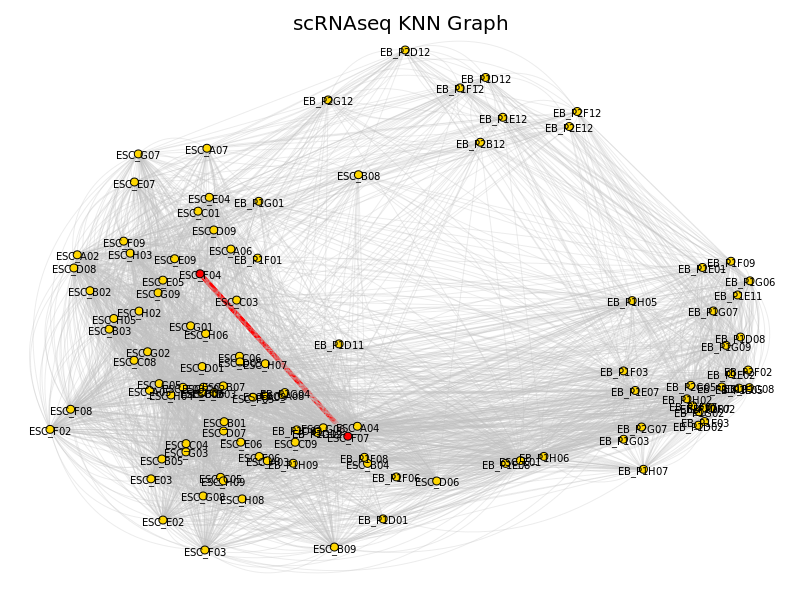

In [14]:
import cairocffi
from igraph import Graph, Plot
from IPython.display import Image
from igraph.drawing.text import TextDrawer

knn_scRNAseq = ig.Graph.TupleList([tuple(x) for x in knn_scRNAseq.values], directed = False)
knn_scRNAseq.vs["label"] = knn_scRNAseq.vs['name']

visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 50

p = Plot("scRNAseq_graph.png", bbox = (800, 600), background = "white")
layout = knn_scRNAseq.layout_mds()
knn_scRNAseq.vs['color'] = ['red' if x['name']  in ['ESC_F04', 'ESC_F07'] else 'gold' for x 
                             in knn_scRNAseq.vs]
knn_scRNAseq.es['color'] = 'rgba(192, 192, 192, 0.3)'
vertex_source = set(['ESC_F04'])
vertex_target = set(['ESC_F07'])
red_edges = knn_scRNAseq.es.select(_source_in = vertex_source, _target_in = vertex_target)
red_edges['color'] = 'red'
red_edges['width'] = 5
p.add(knn_scRNAseq, layout = layout, vertex_size = 8, vertex_label_size = 10, **visual_style)
p.redraw()

ctx = cairocffi.Context(p.surface)
ctx.set_font_size(20)
drawer = TextDrawer(ctx, 'scRNAseq KNN Graph', halign = TextDrawer.CENTER)
drawer.draw_at(300, 30, width = 200)

#plot.show()
p.save()
display(Image('scRNAseq_graph.png', width = 2000))

We already now can observe some sort of clustering of ESC cells and EB cells separately from each other. Now we will do the same graph construction for the scBSseq data. In this case, since scBSseq is a binary data, it is not optimal to measure similarity between cells with the Euclidean distance, the way we did it for scRNAseq data. we will choose the Hamming distance for now, Dice and Jaccard distances might also be a good choice for categorical / binary data.

In [15]:
knn_scBSseq = kneighbors_graph(scBSseq.values, n_neighbor, metric = 'hamming', mode = 'connectivity').toarray()
knn_scBSseq = pd.DataFrame(knn_scBSseq, columns = cell_ids, index = cell_ids)

knn_scBSseq = knn_scBSseq.stack().reset_index()
knn_scBSseq = knn_scBSseq.rename(columns = {'level_0': 'cell1', 'level_1': 'cell2', 0: 'connectivity'})
knn_scBSseq = knn_scBSseq.loc[knn_scBSseq['connectivity'] != 0]

In [16]:
knn_scBSseq[(knn_scBSseq['cell2'] == 'ESC_F04') & (knn_scBSseq['cell1'] == 'ESC_F07')]

cell1    cell2  connectivity
5355  ESC_F07  ESC_F04           1.0

Again the ESC_F04 and ESC_F07 cells seem to be connected in the scBSseq data as well. We will proceed with visualizing the scBSseq KNN graph and highlighting the connection between ESC_F04 and ESC_F07 cells.

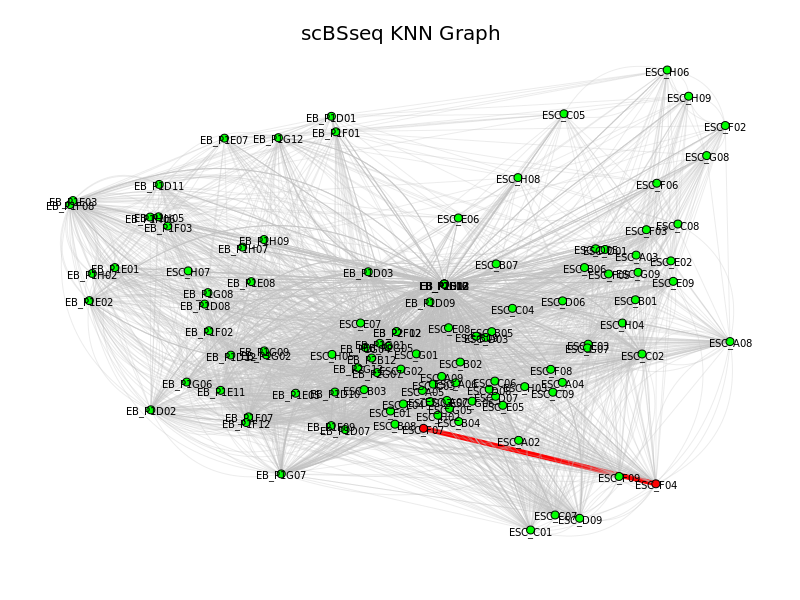

In [17]:
knn_scBSseq = ig.Graph.TupleList([tuple(x) for x in knn_scBSseq.values], directed = False)

knn_scBSseq.vs["label"] = knn_scBSseq.vs['name']

visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 70

p = Plot("scBSseq_graph.png", bbox = (800, 600), background = "white")
layout = knn_scBSseq.layout_mds()
knn_scBSseq.vs['color'] = ['red' if x['name']  in ['ESC_F04', 'ESC_F07'] else 'green' for x 
                             in knn_scBSseq.vs]
knn_scBSseq.es['color'] = 'rgba(192, 192, 192, 0.3)'
vertex_source = set(['ESC_F04'])
vertex_target = set(['ESC_F07'])
red_edges = knn_scBSseq.es.select(_source_in = vertex_source, _target_in = vertex_target)
red_edges['color'] = 'red'
red_edges['width'] = 5

p.add(knn_scBSseq, layout = layout, vertex_size = 8, vertex_label_size = 10, **visual_style)
p.redraw()

ctx = cairocffi.Context(p.surface)
ctx.set_font_size(20)
drawer = TextDrawer(ctx, 'scBSseq KNN Graph', halign=TextDrawer.CENTER)
drawer.draw_at(300, 40, width = 200)

#plot.show()
p.save()
display(Image('scBSseq_graph.png', width = 2000))

And finally we will repeat the same operation (constructing and visualizing KNN graph with Hamming distance) for the scATAC data. Luckily, the ESC_F04 and ESC_F07 cells seem to be connected in this scOmic layer as well. This implies that this graph edge is consistently present across the individual scOmics graphs and therefore should be kept in the consensus graph after we have intersected the individual graphs.

In [18]:
knn_scATACseq = kneighbors_graph(scATACseq.values, n_neighbor, metric = 'hamming', 
                                  mode = 'connectivity').toarray()
knn_scATACseq = pd.DataFrame(knn_scATACseq, columns = cell_ids, index = cell_ids)

knn_scATACseq = knn_scATACseq.stack().reset_index()
knn_scATACseq = knn_scATACseq.rename(columns = {'level_0': 'cell1', 'level_1': 'cell2', 0: 'connectivity'})
knn_scATACseq = knn_scATACseq.loc[knn_scATACseq['connectivity'] != 0]

In [19]:
knn_scATACseq[(knn_scATACseq['cell1'] == 'ESC_F04') & (knn_scATACseq['cell2'] == 'ESC_F07')]

cell1    cell2  connectivity
5019  ESC_F04  ESC_F07           1.0

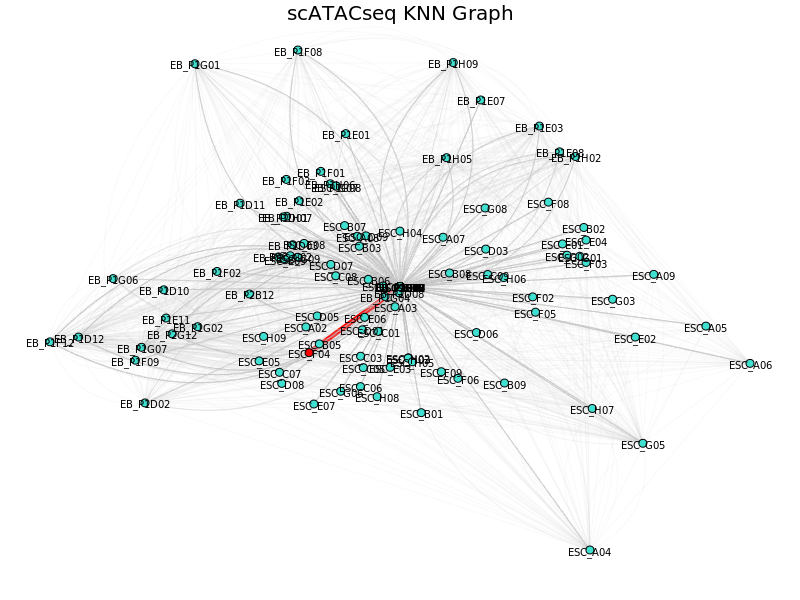

In [20]:
knn_scATACseq = ig.Graph.TupleList([tuple(x) for x in knn_scATACseq.values], directed = False)

knn_scATACseq.vs["label"] = knn_scATACseq.vs['name']

visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 50

p = Plot("scATACseq_graph.png", bbox = (800, 600), background = "white")
layout = knn_scATACseq.layout_mds()
knn_scATACseq.vs['color'] = ['red' if x['name']  in ['ESC_F04', 'ESC_F07'] else 'turquoise' for x 
                             in knn_scATACseq.vs]
knn_scATACseq.es['color'] = 'rgba(192, 192, 192, 0.1)'
vertex_source = set(['ESC_F04'])
vertex_target = set(['ESC_F07'])
red_edges = knn_scATACseq.es.select(_source_in = vertex_source, _target_in = vertex_target)
red_edges['color'] = 'red'
red_edges['width'] = 5

p.add(knn_scATACseq, layout = layout, vertex_size = 8, vertex_label_size = 10, **visual_style)
p.redraw()

ctx = cairocffi.Context(p.surface)
ctx.set_font_size(20)
drawer = TextDrawer(ctx, 'scATACseq KNN Graph', halign=TextDrawer.CENTER)
drawer.draw_at(300, 20, width = 200)

#plot.show()
p.save()
display(Image('scATACseq_graph.png', width = 2000))

Great! Now we have constructed 3 KNN graphs from scRNAseq, scBSseq, and scATACseq data sets. Now everything is ready for running intersection of the 3 graphs. The idea of graph intersection, as it beautifully demonstrated in Wolfram Mathworld (https://mathworld.wolfram.com/), is to keep edge consitently present across multiple scOmics data sets. We will is the "intersection" function implemented in the **igraph** library. some nodes are going to be isolated after we have performed the graph intersection. For simplicity, here, we are going to ignore / delete those nodes and not consider them as separate clusters.

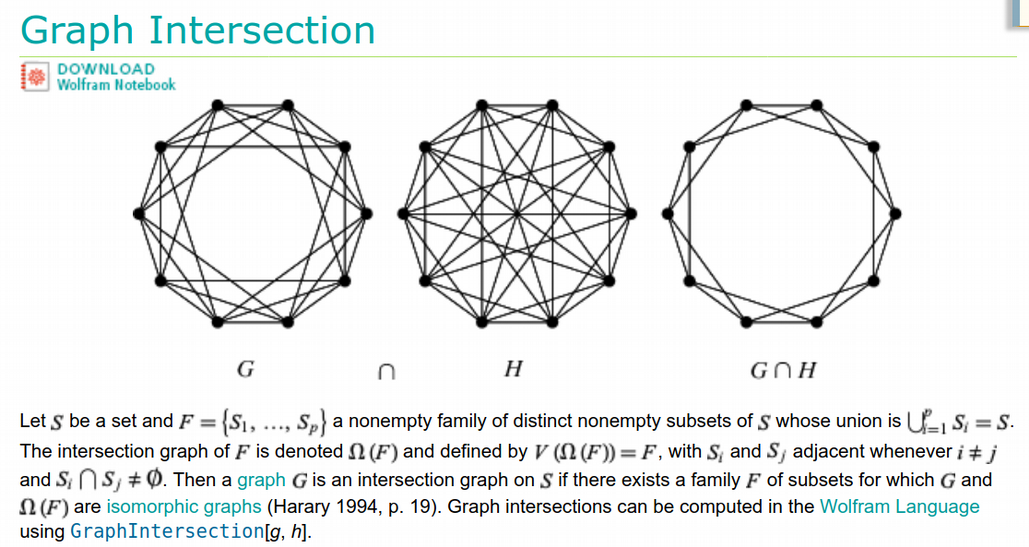

In [21]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/UMAP_DataIntegration/GraphIntersection.png', width=2000)

In [23]:
from igraph import intersection
knn_consensus = intersection([knn_scRNAseq, knn_scBSseq, knn_scATACseq])

In [24]:
to_delete_ids = [v.index for v in knn_consensus.vs if v.degree() == 0]
knn_consensus.delete_vertices(to_delete_ids)

In [25]:
to_delete_ids

[7, 11, 40, 80, 100, 109, 111, 112]

In [28]:
knn_consensus

Let us visualize the **consensus graph** (the one obtained by intersecting the other 3 graphs) and demonstrate that the connection / edge between ESC_F04 and ESC_F07 cells is still present, we will highlight this edge by red.

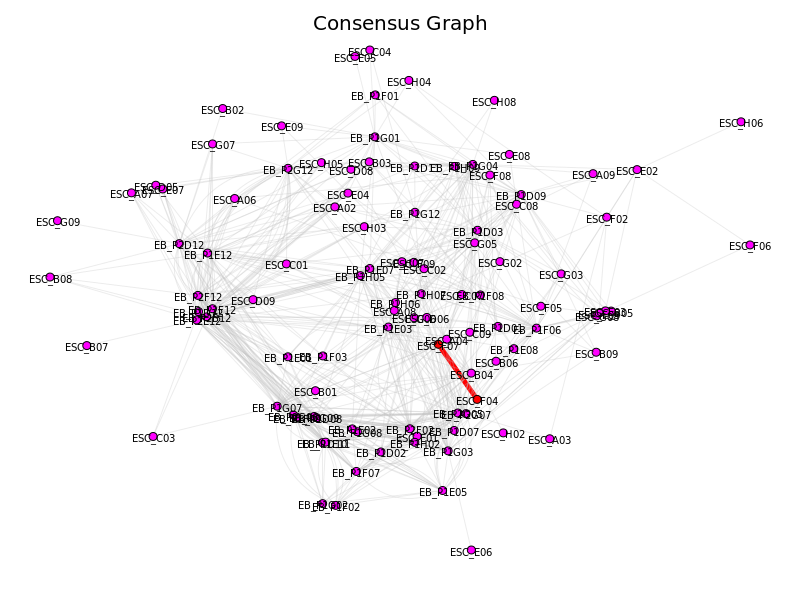

In [29]:
visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 50

p = Plot("consensus_graph.png", bbox = (800, 600), background = "white")
layout = knn_consensus.layout_mds()

knn_consensus.vs['color'] = ['red' if x['name']  in ['ESC_F04', 'ESC_F07'] else 'magenta' for x 
                             in knn_consensus.vs]
knn_consensus.es['color'] = 'rgba(192, 192, 192, 0.3)'
vertex_source = set(['ESC_F04'])
vertex_target = set(['ESC_F07'])
red_edges = knn_consensus.es.select(_source_in = vertex_source, _target_in = vertex_target)
red_edges['color'] = 'red'
red_edges['width'] = 5

p.add(knn_consensus, layout = layout, vertex_size = 8, vertex_label_size = 10, **visual_style)
p.redraw()

ctx = cairocffi.Context(p.surface)
ctx.set_font_size(20)
drawer = TextDrawer(ctx, 'Consensus Graph', halign=TextDrawer.CENTER)
drawer.draw_at(300, 30, width = 200)

#plot.show()
p.save()
display(Image('consensus_graph.png', width = 2000))

Now we can run Leiden (https://www.nature.com/articles/s41598-019-41695-z) graph-based clustering algorithm (modification of Louvain algorithm), that finds 4 clusters present on the consensus graph.

In [30]:
import leidenalg
knn_consensus_cluster = leidenalg.find_partition(knn_consensus, leidenalg.ModularityVertexPartition)

In [31]:
knn_consensus_cluster.modularity

0.34334201388888896

In [32]:
knn_consensus_cluster.membership[0:10]

[2, 0, 0, 1, 1, 2, 0, 2, 0, 2]

In [33]:
len(knn_consensus_cluster)

4

we will color the nodes on the consensus graph by the membership determined by the Leiden graph-based clustering algorithm. The consistent across the scOmics connection between the ESC_F04 and ESC_F07 cells is stil highlighted by red.

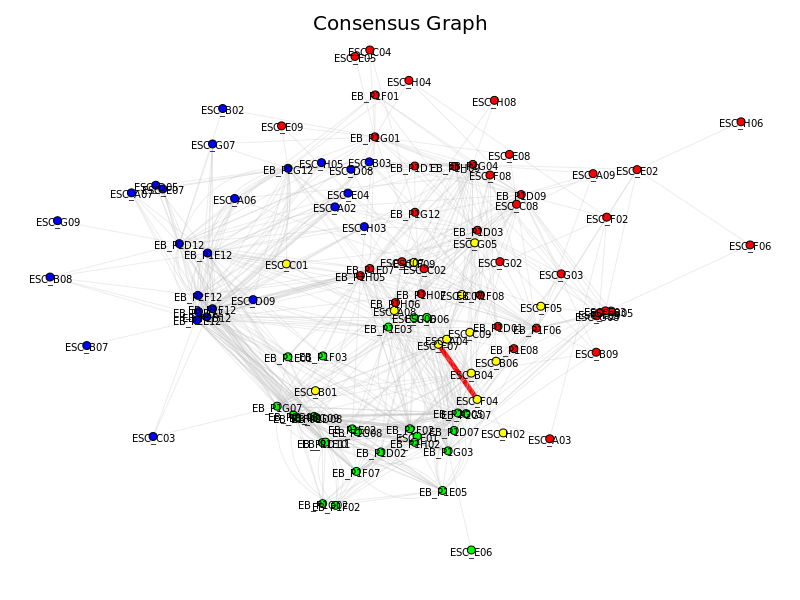

In [34]:
visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 50

p = Plot("consensus_graph.png", bbox = (800, 600), background = "white")
layout = knn_consensus.layout_mds()

pal = ig.drawing.colors.ClusterColoringPalette(len(knn_consensus_cluster))
knn_consensus.vs['color'] = pal.get_many(knn_consensus_cluster.membership)
p.add(knn_consensus, layout = layout, vertex_size = 8, vertex_label_size = 10, **visual_style)
p.redraw()

ctx = cairocffi.Context(p.surface)
ctx.set_font_size(20)
drawer = TextDrawer(ctx, 'Consensus Graph', halign = TextDrawer.CENTER)
drawer.draw_at(300, 30, width = 200)

#plot.show()
p.save()
display(Image('consensus_graph.png', width = 2000))

We can see that the EB cells seem to form a separate (green) cluster, while the ESC cells are now split into at least two (blue and red) clusters. There is a minor group of yellow cells that was found to be the fourth cluster but this probably should be tuned with the resolution parameter of the Leiden algorithm as the yellow cells do not seem to visually stand out as a separate cluster. On the other hand this might be an issues with the layout. Trying anohter graph layout could possible demonstrate that the yellow cells indeed form a distinct cluster.

### UMAP for Single Cell Omics Integration <a class="anchor" id="UMAP-for-Single-Cell-Omics-Integration"></a>

It turns out that the manual KNN graph construction and intersection is not really necessary as this option is essentially included into UMAP algorithm. UMAP allows for fast individual scOmics graph building and intersection wioth just a few lines of code, see the interesting discussion about mixing different data types here https://github.com/lmcinnes/umap/issues/58.

Here we will overlap graphs from single cell RNAseq and Proteomics data sets from the CITE-seq technology (https://en.wikipedia.org/wiki/CITE-Seq), and produce a consensus / integrative OMICs UMAP plot. The idea is to convert the two data types into graphs, i.e. non-parametric space where they forget their technological differences, and overlap the graphs. The resulting graph will be used for constructing the UMAP embeddings.

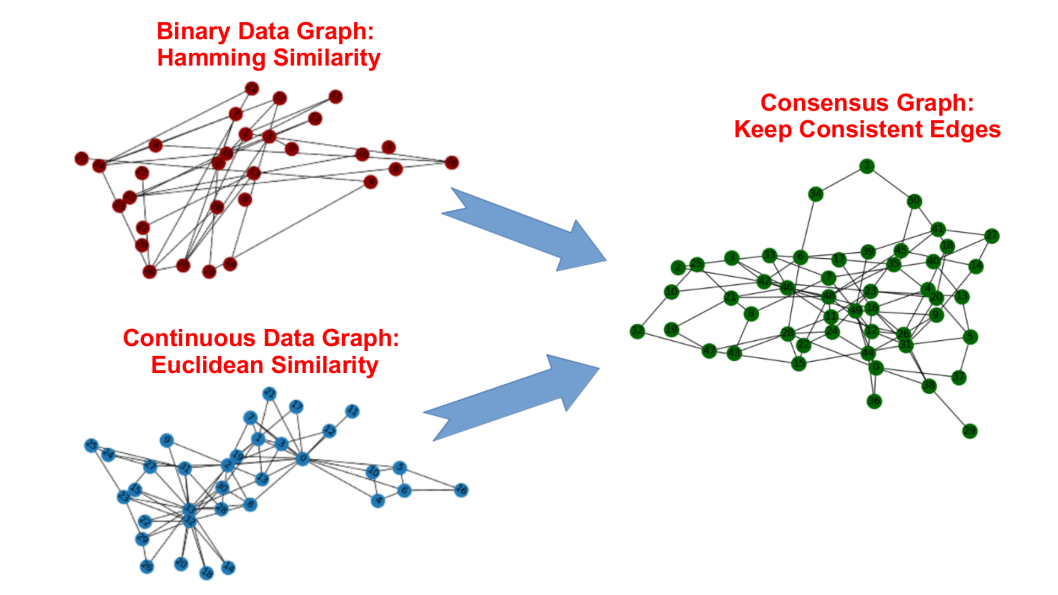

In [35]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/UMAP_DataIntegration/GraphDataIntegration.png', width = 2000)

By graph intersection we mean keeping edges consitently present across the different data sets:

We will start with reading and log-transforming the OMICs data.

In [2]:
import os
import numpy as np
import pandas as pd
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils import plot_model
from keras.layers import Input, Dense
from keras.layers.merge import concatenate

os.chdir('/home/nikolay/WABI/Misc/SingleCell/CITEseq/')

scRNAseq = pd.read_csv('scRNAseq.txt',sep='\t')
scProteomics = pd.read_csv('scProteomics.txt',sep='\t')

X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.values[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.values[:,scProteomics.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)

Using TensorFlow backend.


In [3]:
X_scRNAseq.shape

(8617, 976)

In [4]:
X_scProteomics.shape

(8617, 10)

Let us display the UMAP embeddings of individual OMICs data sets. We will start with the scRNAseq dataset. As an optimal number of nearest neighbors we will choose sqrt(N) = sqrt(8617) = 93.

UMAP(init=array([[45.31235894,  0.07477159],
       [46.53271754,  1.71486063],
       [46.8638235 ,  0.98846408],
       ...,
       [ 1.11426643, -1.86512337],
       [ 4.54796886, -0.69171758],
       [ 2.61794017, -0.97065852]]),
     min_dist=1, n_epochs=1000, n_neighbors=93, verbose=2)
Construct fuzzy simplicial set
Tue Sep 29 20:27:30 2020 Finding Nearest Neighbors
Tue Sep 29 20:27:30 2020 Building RP forest with 10 trees
Tue Sep 29 20:27:31 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Sep 29 20:27:44 2020 Finished Nearest Neighbor Search
Tue Sep 29 20:27:47 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Sep 29 20:28:21 2020 Finished embedding


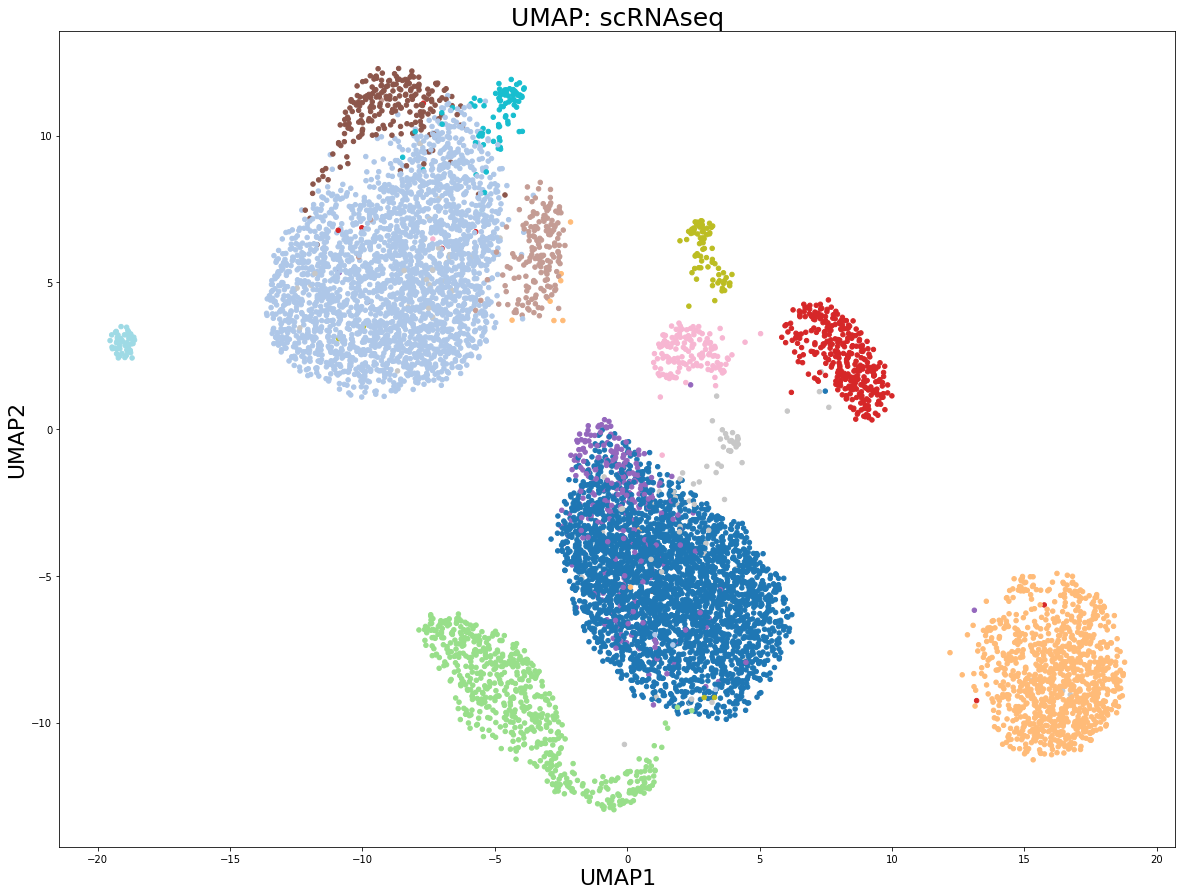

In [5]:
import warnings
warnings.filterwarnings("ignore")

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_reduced = PCA(n_components = 20).fit_transform(X_scRNAseq)
model = UMAP(n_components = 2, min_dist = 1, n_neighbors = 93, init = X_reduced[:, 0:2], n_epochs = 1000, 
             verbose = 2)
umap = model.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 20)
plt.title('UMAP: scRNAseq', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()

Now let us display UMAP embeddings for the scProteomics dataset of the CITE-seq sequencing technology.

UMAP(init=array([[-1.65366402, -0.2564025 ],
       [-1.7084814 ,  1.69115812],
       [-1.03060202, -0.13172222],
       ...,
       [-2.19859839, -5.16795233],
       [-2.10143214, -2.48594223],
       [-2.43134931, -3.33697131]]),
     min_dist=0.8, n_epochs=1000, n_neighbors=93, verbose=2)
Construct fuzzy simplicial set
Tue Sep 29 20:32:11 2020 Finding Nearest Neighbors
Tue Sep 29 20:32:11 2020 Building RP forest with 10 trees
Tue Sep 29 20:32:11 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
Tue Sep 29 20:32:17 2020 Finished Nearest Neighbor Search
Tue Sep 29 20:32:18 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Sep 29 20:32:52 2020 Finished embedding


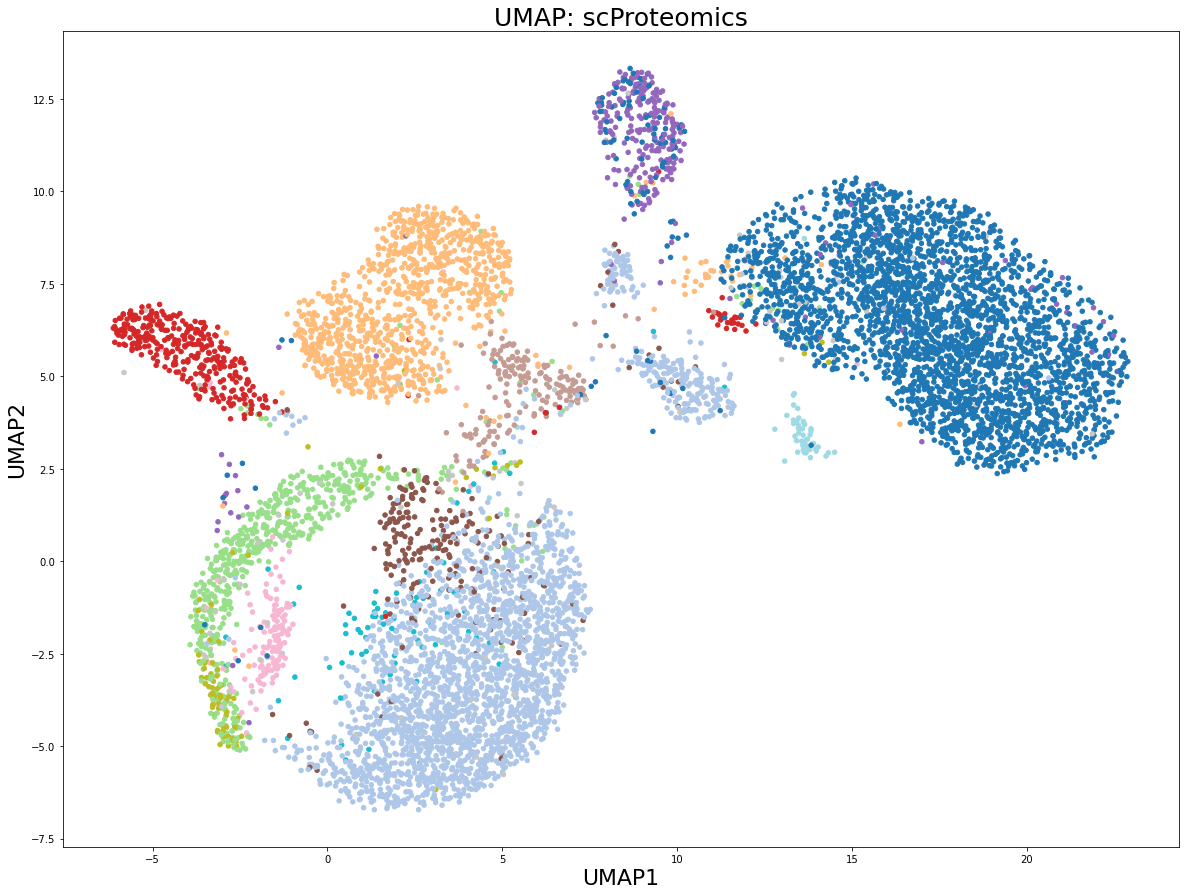

In [9]:
import warnings
warnings.filterwarnings("ignore")

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_reduced = PCA(n_components = 10).fit_transform(X_scProteomics)
model = UMAP(n_components = 2, min_dist = 0.8, n_neighbors = 93, init = X_reduced[:, 0:2], n_epochs = 1000, 
             verbose = 2)
umap = model.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 20)
plt.title('UMAP: scProteomics', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()

Now we will construct the intersection of the two graphs / simplicial sets, and visualize the resulting embeddings.

In [16]:
import umap

X_reduced_scRNAseq = PCA(n_components = 20).fit_transform(X_scRNAseq)
X_reduced_scProteomics = PCA(n_components = 10).fit_transform(X_scProteomics)

fit1 = umap.UMAP(n_components = 2, min_dist = 1, n_neighbors = 93, n_epochs = 1000, 
                 init = X_reduced_scRNAseq[:, 0:2], verbose = 2).fit(X_reduced_scRNAseq)
fit2 = umap.UMAP(n_components = 2, min_dist = 0.8, n_neighbors = 93, n_epochs = 1000, 
                 init = X_reduced_scProteomics[:, 0:2], verbose = 2).fit(X_reduced_scProteomics)
intersection = umap.umap_. general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight = 0.45)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1.learning_rate, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                1000, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

UMAP(init=array([[45.31235894,  0.07477159],
       [46.53271754,  1.71486063],
       [46.8638235 ,  0.98846408],
       ...,
       [ 1.11426643, -1.86512337],
       [ 4.54796886, -0.69171758],
       [ 2.61794017, -0.97065852]]),
     min_dist=1, n_epochs=1000, n_neighbors=93, verbose=2)
Construct fuzzy simplicial set
Tue Sep 29 20:41:09 2020 Finding Nearest Neighbors
Tue Sep 29 20:41:09 2020 Building RP forest with 10 trees
Tue Sep 29 20:41:09 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Sep 29 20:41:16 2020 Finished Nearest Neighbor Search
Tue Sep 29 20:41:17 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Sep 29 20:41:52 2020 Finished embedding
UMAP(init=array

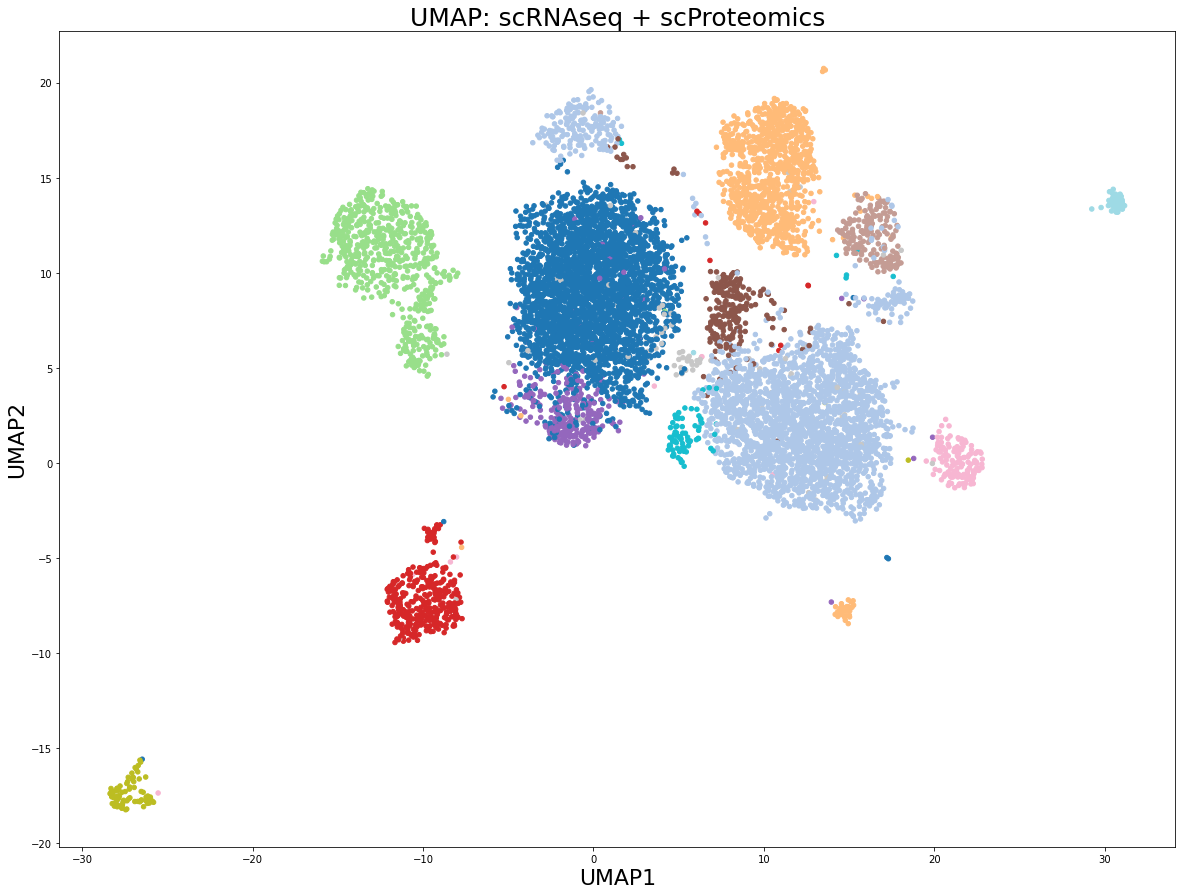

In [17]:
plt.figure(figsize = (20,15))
plt.scatter(embedding[:, 0], embedding[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 20)
plt.title('UMAP: scRNAseq + scProteomics', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()